In [ ]:
import torch
import math
import matplotlib.pyplot as plt

from PIL import Image
from diffusers import FluxPipeline
from torch import Tensor
from torchvision import transforms

DTYPE = torch.bfloat16
pipe = FluxPipeline.from_pretrained("/root/autodl-tmp/Flux-dev", torch_dtype=DTYPE)
pipe.to("cuda")

In [2]:
@torch.inference_mode()
def decode_imgs(latents, pipeline):
    imgs = (latents / pipeline.vae.config.scaling_factor) + pipeline.vae.config.shift_factor
    imgs = pipeline.vae.decode(imgs)[0]
    imgs = pipeline.image_processor.postprocess(imgs, output_type="pil")
    return imgs

@torch.inference_mode()
def encode_imgs(imgs, pipeline):
    latents = pipeline.vae.encode(imgs).latent_dist.sample()
    latents = (latents - pipeline.vae.config.shift_factor) * pipeline.vae.config.scaling_factor
    latents = latents.to(dtype=DTYPE)
    return latents

In [ ]:
img = Image.open("/root/rf-inversion/example/cat.png")

train_transforms = transforms.Compose(
            [
                transforms.Resize(1024, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.CenterCrop(1024),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )

img = train_transforms(img).unsqueeze(0).to("cuda").to(DTYPE)

img_latent = encode_imgs(img, pipe)
img_rec = decode_imgs(img_latent, pipe)[0]

plt.figure(figsize=(8, 8))
plt.imshow(img_rec)

In [5]:
def time_shift(mu: float, sigma: float, t: Tensor):
    return math.exp(mu) / (math.exp(mu) + (1 / t - 1) ** sigma)

def get_lin_function(
    x1: float = 256, y1: float = 0.5, x2: float = 4096, y2: float = 1.15
):
    m = (y2 - y1) / (x2 - x1)
    b = y1 - m * x1
    return lambda x: m * x + b

def get_schedule(
    num_steps: int,
    image_seq_len: int,
    base_shift: float = 0.5,
    max_shift: float = 1.15,
    shift: bool = True,
) -> list[float]:
    # extra step for zero
    timesteps = torch.linspace(1, 0, num_steps + 1, dtype=torch.float32)

    # shifting the schedule to favor high timesteps for higher signal images
    if shift:
        # eastimate mu based on linear estimation between two points
        mu = get_lin_function(y1=base_shift, y2=max_shift)(image_seq_len)
        timesteps = time_shift(mu, 1.0, timesteps)

    return timesteps.tolist()

In [ ]:
@torch.inference_mode()
def interpolated_inversion(
    pipeline, 
    timesteps, 
    latents,
    gamma,
):
    prompt_embeds, pooled_prompt_embeds, text_ids = pipeline.encode_prompt( # null text
        prompt="", 
        prompt_2=""
    )
    latent_image_ids = FluxPipeline._prepare_latent_image_ids(
        latents.shape[0],
        latents.shape[2],
        latents.shape[3],
        latents.device,
        DTYPE,
    )
    packed_latents = FluxPipeline._pack_latents( # shape [num_samples, (resolution // 16 * resolution // 16), 16 * 2 * 2]
        latents,
        batch_size=latents.shape[0],
        num_channels_latents=latents.shape[1],
        height=latents.shape[2],
        width=latents.shape[3],
    )
    
    target_noise = torch.randn(packed_latents.shape, device=packed_latents.device, dtype=torch.float32)
    guidance_scale=0.0 # zero guidance for inversion
    guidance_vec = torch.full((packed_latents.shape[0],), guidance_scale, device=packed_latents.device, dtype=packed_latents.dtype)

    # Image inversion with interpolated velocity filed.  t goes from 0.0 to 1.0
    with pipeline.progress_bar(total=len(timesteps)-1) as progress_bar:
        for t_curr, t_prev in zip(timesteps[:-1], timesteps[1:]):
            t_vec = torch.full((packed_latents.shape[0],), t_curr, dtype=packed_latents.dtype, device=packed_latents.device)
            
            # Null text velocity
            flux_velocity = pipeline.transformer(
                    hidden_states=packed_latents, # shape: [batch_size, seq_len, num_channels_latents], e.g. [1, 4096, 64] for 1024x1024
                    timestep=t_vec,               # range: [0, 1]
                    guidance=guidance_vec,        # scalar guidance values for each sample in the batch
                    pooled_projections=pooled_prompt_embeds, # CLIP text embedding
                    encoder_hidden_states=prompt_embeds,     # T5 text embedding
                    txt_ids=text_ids,
                    img_ids=latent_image_ids,
                    joint_attention_kwargs=None,
                    return_dict=pipeline,
                )[0]
            
			# Prevents precision issues
            packed_latents = packed_latents.to(torch.float32)
            flux_velocity = flux_velocity.to(torch.float32)

            # Target noise velocity
            target_noise_velocity = (target_noise - packed_latents) / (1.0 - t_curr)
            print(f"Target noise velocity = (X_1' - X_{t_curr:.3f}) / {1 - t_curr:.3f}")
            
            # interpolated velocity
            interpolated_velocity = gamma * target_noise_velocity + (1 - gamma) * flux_velocity
            
			# one step Euler
            packed_latents = packed_latents + (t_prev - t_curr) * interpolated_velocity
            print(f"X_{t_prev:.3f} = X_{t_curr:.3f} + {t_prev - t_curr:.3f} * interpolated velocity")
            
            packed_latents = packed_latents.to(DTYPE)
            progress_bar.update()
    
    latents = FluxPipeline._unpack_latents( # save, shape [num_samples, 16, resolution//8, resolution//8]
            packed_latents,
            height=1024,
            width=1024,
            vae_scale_factor=pipeline.vae_scale_factor,
    )
    latents = latents.to(DTYPE)
    return latents

timesteps = get_schedule( 
                num_steps=50,
                image_seq_len=(1024 // 16) * (1024 // 16), # vae_scale_factor = 16
                shift=False,  # Set True for Flux-dev, False for Flux-schnell
            )[::-1] # flipped for inversion

print(timesteps)

inversed_latent = interpolated_inversion(pipe, timesteps, img_latent, gamma=0.5)

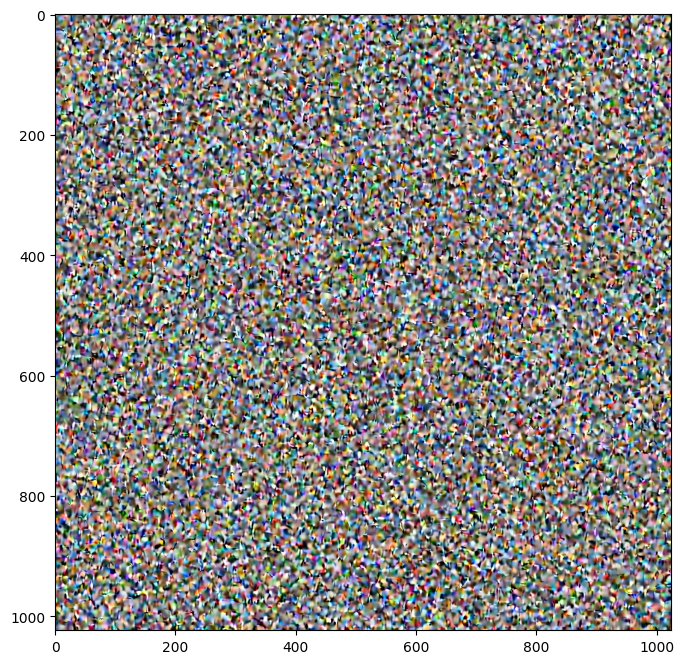

In [33]:
img = decode_imgs(inversed_latent, pipe)[0]

plt.figure(figsize=(8, 8))
plt.imshow(img)

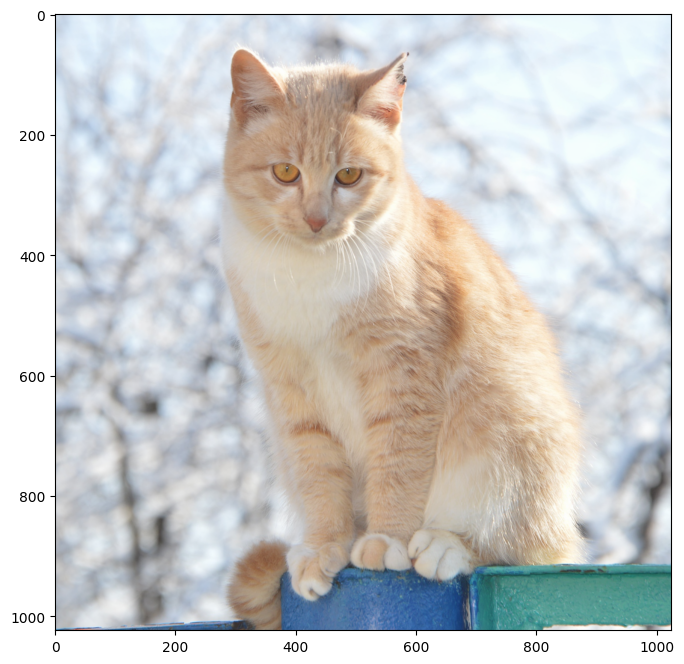

In [36]:
img = decode_imgs(img_latent, pipe)[0]

plt.figure(figsize=(8, 8))
plt.imshow(img)

  0%|          | 0/50 [00:00<?, ?it/s]

Target noise velocity = (X_0' - X_1.000) / 1.000
X_0.980 = X_1.000 + -0.020 * interpolated velocity
Target noise velocity = (X_0' - X_0.980) / 0.980
X_0.960 = X_0.980 + -0.020 * interpolated velocity
Target noise velocity = (X_0' - X_0.960) / 0.960
X_0.940 = X_0.960 + -0.020 * interpolated velocity
Target noise velocity = (X_0' - X_0.940) / 0.940
X_0.920 = X_0.940 + -0.020 * interpolated velocity
Target noise velocity = (X_0' - X_0.920) / 0.920
X_0.900 = X_0.920 + -0.020 * interpolated velocity
Target noise velocity = (X_0' - X_0.900) / 0.900
X_0.880 = X_0.900 + -0.020 * interpolated velocity
Target noise velocity = (X_0' - X_0.880) / 0.880
X_0.860 = X_0.880 + -0.020 * interpolated velocity
Target noise velocity = (X_0' - X_0.860) / 0.860
X_0.840 = X_0.860 + -0.020 * interpolated velocity
Target noise velocity = (X_0' - X_0.840) / 0.840
X_0.820 = X_0.840 + -0.020 * interpolated velocity
Target noise velocity = (X_0' - X_0.820) / 0.820
X_0.800 = X_0.820 + -0.020 * interpolated velocity


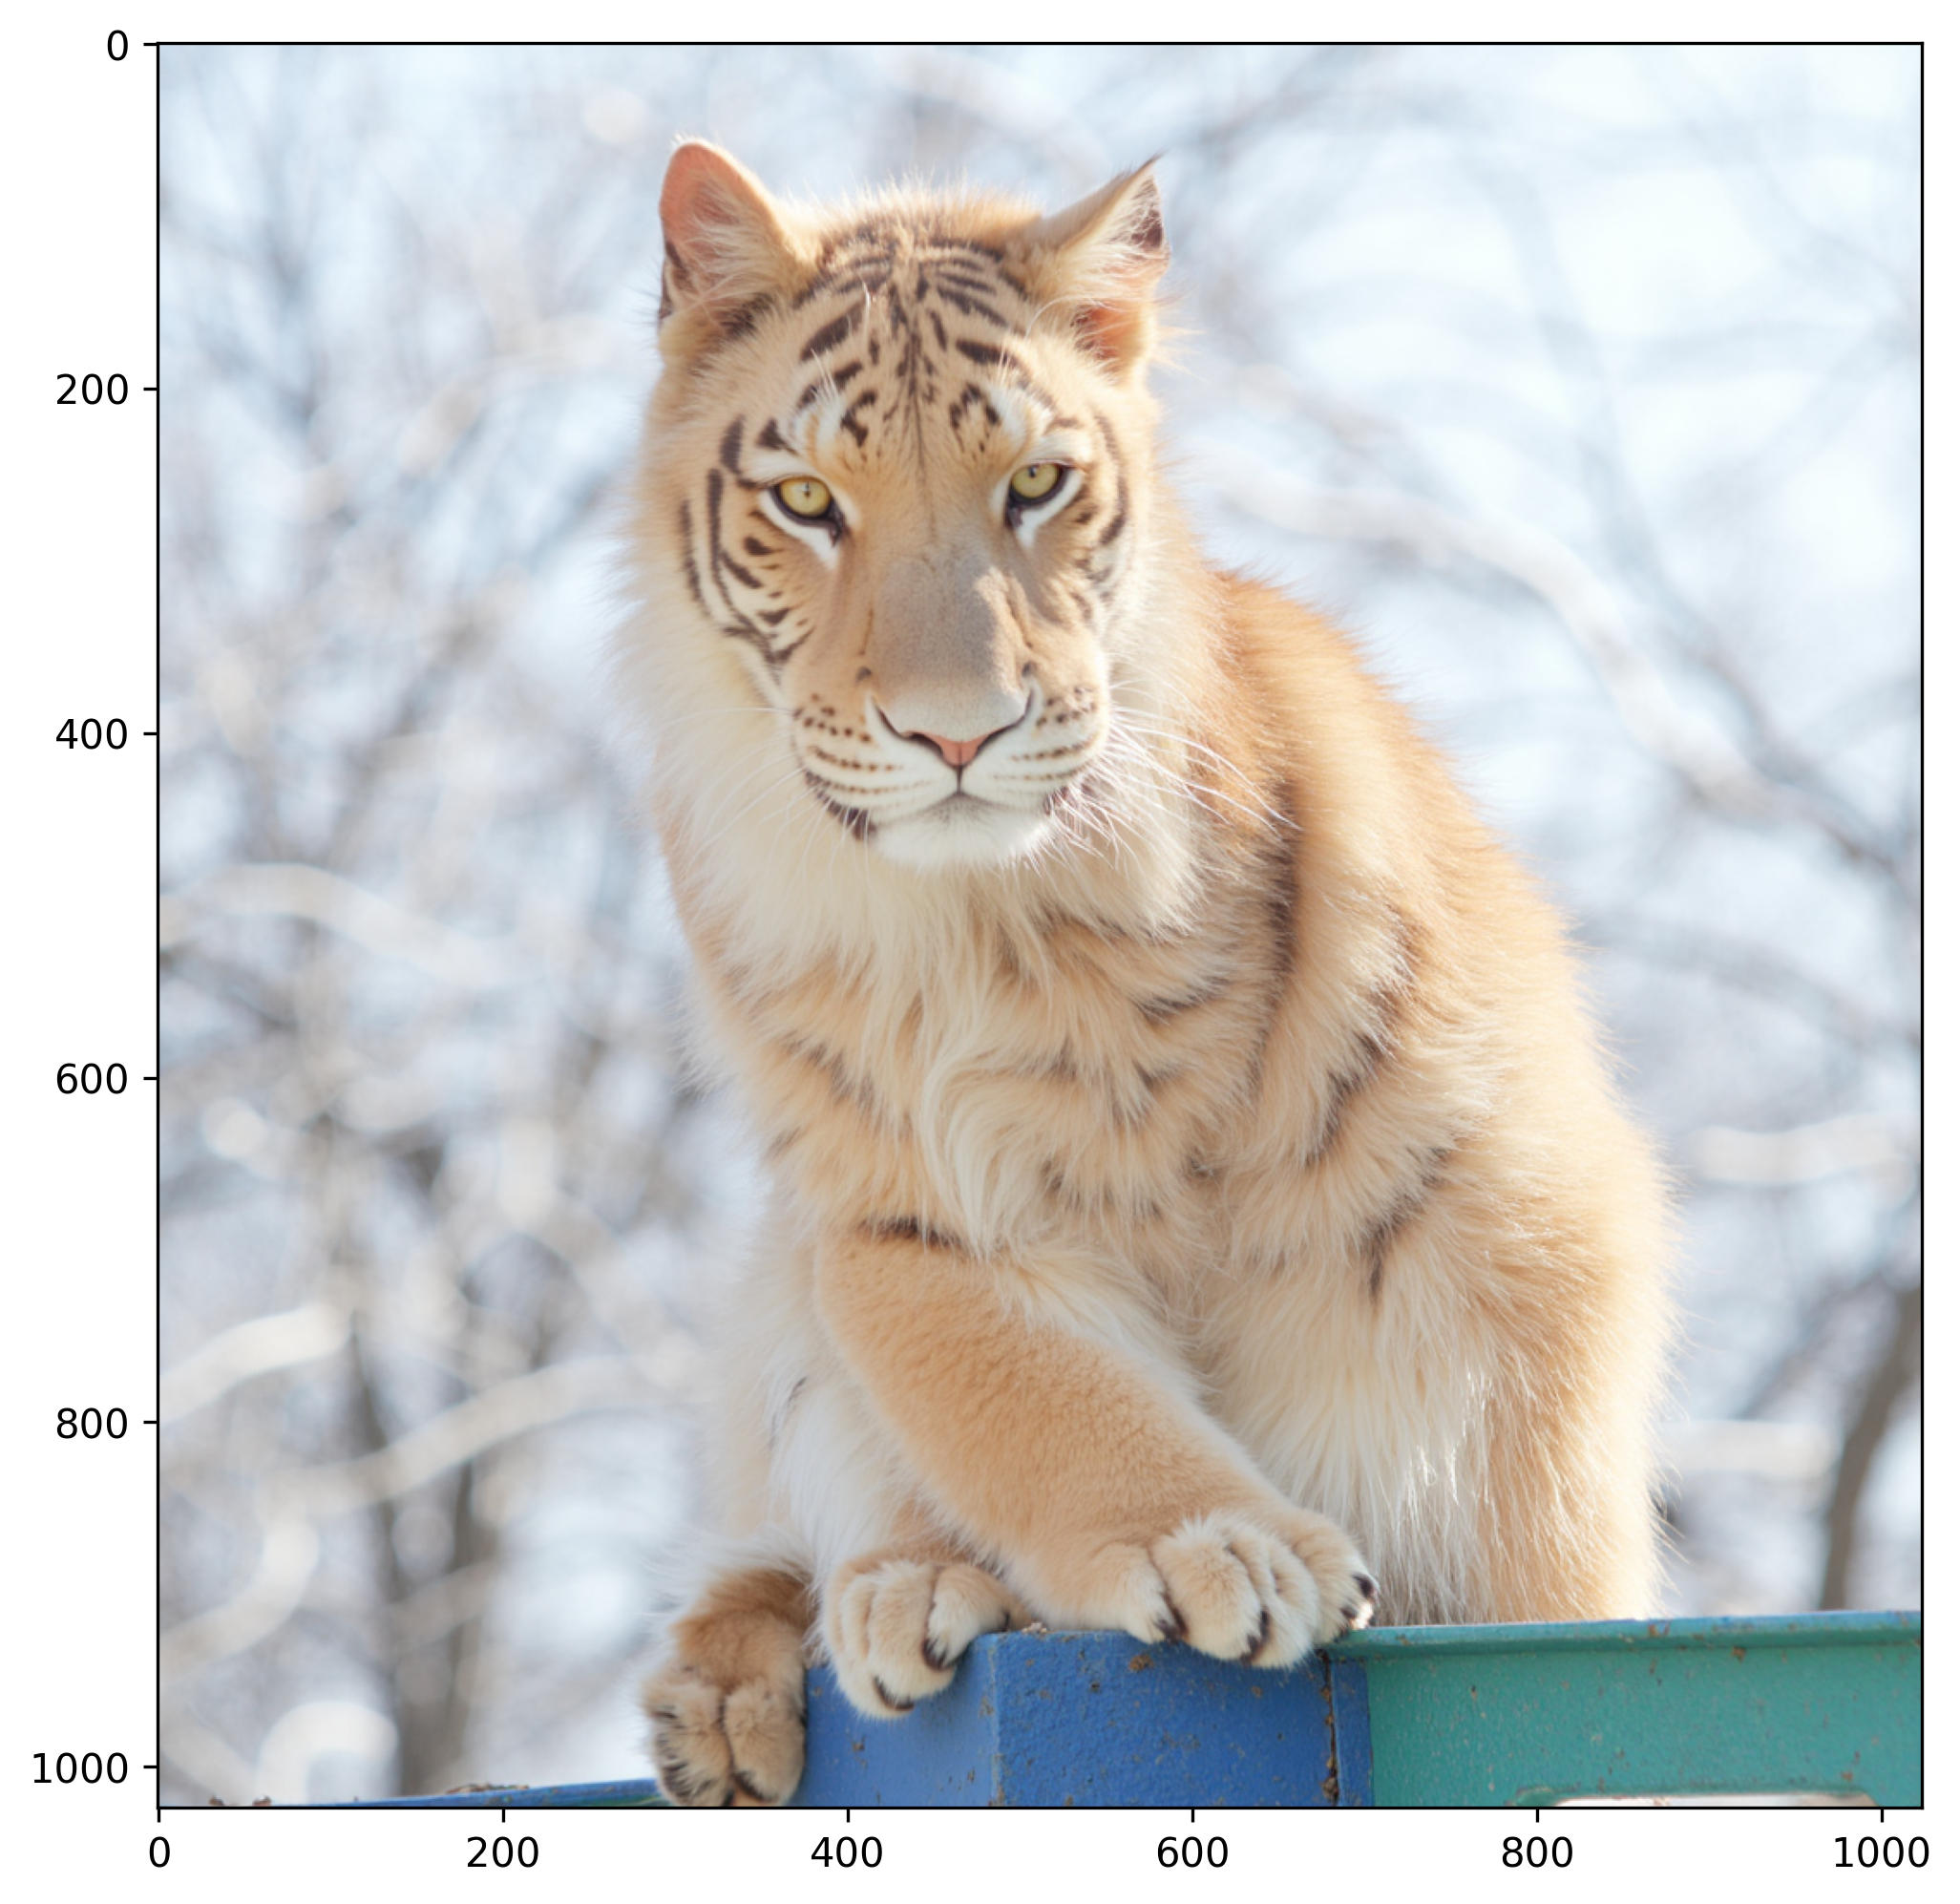

In [35]:
@torch.inference_mode()
def interpolated_denoise(
    pipeline, 
    timesteps, 
    inversed_latents,
    img_latents,
    eta,
    start_time=1.0,
    end_time=0.6,
):
    prompt_embeds, pooled_prompt_embeds, text_ids = pipeline.encode_prompt( # null text
        prompt="a photo of a tiger", 
        prompt_2="a photo of a tiger"
    )
    latent_image_ids = FluxPipeline._prepare_latent_image_ids(
        inversed_latents.shape[0],
        inversed_latents.shape[2],
        inversed_latents.shape[3],
        inversed_latents.device,
        DTYPE,
    )
    packed_latents = FluxPipeline._pack_latents( # shape [num_samples, (resolution // 16 * resolution // 16), 16 * 2 * 2]
        inversed_latents,
        batch_size=inversed_latents.shape[0],
        num_channels_latents=inversed_latents.shape[1],
        height=inversed_latents.shape[2],
        width=inversed_latents.shape[3],
    )
    packed_img_latents = FluxPipeline._pack_latents( # shape [num_samples, (resolution // 16 * resolution // 16), 16 * 2 * 2]
        img_latents,
        batch_size=img_latents.shape[0],
        num_channels_latents=img_latents.shape[1],
        height=img_latents.shape[2],
        width=img_latents.shape[3],
	)
    
    target_img = packed_img_latents.clone().to(torch.float32)
    guidance_scale=3.5 # zero guidance for inversion
    guidance_vec = torch.full((packed_latents.shape[0],), guidance_scale, device=packed_latents.device, dtype=packed_latents.dtype)

    # Denoising with interpolated velocity filed.  t goes from 1.0 to 0.0
    with pipeline.progress_bar(total=len(timesteps)-1) as progress_bar:
        for t_curr, t_prev in zip(timesteps[:-1], timesteps[1:]):
            t_vec = torch.full((packed_latents.shape[0],), t_curr, dtype=packed_latents.dtype, device=packed_latents.device)
            
            # Editing text velocity
            flux_velocity = pipeline.transformer(
                    hidden_states=packed_latents, # shape: [batch_size, seq_len, num_channels_latents], e.g. [1, 4096, 64] for 1024x1024
                    timestep=t_vec,               # range: [0, 1]
                    guidance=guidance_vec,        # scalar guidance values for each sample in the batch
                    pooled_projections=pooled_prompt_embeds, # CLIP text embedding
                    encoder_hidden_states=prompt_embeds,     # T5 text embedding
                    txt_ids=text_ids,
                    img_ids=latent_image_ids,
                    joint_attention_kwargs=None,
                    return_dict=pipeline,
                )[0]
            
            # Prevents precision issues
            packed_latents = packed_latents.to(torch.float32)
            flux_velocity = flux_velocity.to(torch.float32)

            # Target noise velocity
            target_img_velocity = -(target_img - packed_latents) / t_curr
            print(f"Target noise velocity = (X_0' - X_{t_curr:.3f}) / {t_curr:.3f}")
            
            # interpolated velocity
            interpolated_velocity = eta * target_img_velocity + (1 - eta) * flux_velocity
            
            # one step Euler
            if end_time <= t_curr <= start_time:
                packed_latents = packed_latents + (t_prev - t_curr) * interpolated_velocity
                print(f"X_{t_prev:.3f} = X_{t_curr:.3f} + {t_prev - t_curr:.3f} * interpolated velocity")
            else:
                packed_latents = packed_latents + (t_prev - t_curr) * flux_velocity
                print(f"X_{t_prev:.3f} = X_{t_curr:.3f} + {t_prev - t_curr:.3f} * flux velocity")
            
            packed_latents = packed_latents.to(DTYPE)
            progress_bar.update()
    
    latents = FluxPipeline._unpack_latents( # save, shape [num_samples, 16, resolution//8, resolution//8]
            packed_latents,
            height=1024,
            width=1024,
            vae_scale_factor=pipeline.vae_scale_factor,
    )
    latents = latents.to(DTYPE)
    return latents

timesteps = get_schedule(
				num_steps=50,
				image_seq_len=(1024 // 16) * (1024 // 16), # vae_scale_factor = 16
				shift=False,  # Set True for Flux-dev, False for Flux-schnell
			)

img_latents = interpolated_denoise(
    pipe, 
	timesteps,
	inversed_latent,
	img_latent,
	eta=0.7,
	start_time=1.0,
	end_time=0.6,
)

out = decode_imgs(img_latents, pipe)[0]

plt.figure(figsize=(8, 8), dpi=300)
plt.imshow(out)